In [1]:
#import all the stuff:
import awkward as ak
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.regularizers import l1
from keras_tuner.tuners import RandomSearch
import os, datetime
from sklearn.utils.class_weight import compute_class_weight
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import F1Score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from keras.callbacks import LearningRateScheduler

#replace if you want to rerun smallnetdata:
inpath = "smallnet_outputs_for_training_2024_09_07-03_06_22_PM/"
X_train = ak.to_numpy(ak.from_parquet(inpath +"X_train_scaled.parquet")  )
y_train = ak.to_numpy(ak.from_parquet(inpath +"y_train_scaled.parquet"))
X_test =  ak.to_numpy(ak.from_parquet(inpath +"X_test_scaled.parquet"))
y_test = ak.to_numpy(ak.from_parquet(inpath +"y_test_scaled.parquet"))
print(type(y_train[0]))
print(type(y_test[0]))
unique, counts_train = np.unique([y_train], return_counts=True)
print(counts_train)

unique, counts_test = np.unique([y_test], return_counts=True)
print(counts_test)



2024-09-07 17:13:32.856429: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-07 17:13:32.933660: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<class 'numpy.float64'>
<class 'numpy.float64'>
[151119  52836]
[100710  35260]


In [2]:
#has to add up to the data preperation:
print("Total Falses:",counts_test[0]+counts_train[0])
print("Total Trues:",counts_test[1]+counts_train[1])

Total Falses: 251829
Total Trues: 88096


In [3]:

# Define the model-building function
def build_model(hp):
    model = Sequential()
    
    # First Dense Layer
    model.add(Dense(
        units=hp.Int('units_fc1', min_value=128, max_value=512, step=64),
        input_shape=(X_train.shape[1],),
        name='fc1',
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(hp.Float('reg1', 0.0001, 0.001, step=0.0001)),
        bias_regularizer=l1(hp.Float('regb1', 0.0001, 0.001, step=0.0001)),

    ))
    model.add(Activation(activation='relu', name='relu1'))
    model.add(Dropout(hp.Float('dropout_fc1', 0.1, 0.3, step=0.1)))
    
    # Second Dense Layer
    model.add(Dense(
        units=hp.Int('units_fc2', min_value=32, max_value=512, step=32),
        name='fc2',
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(hp.Float('reg2', 0.0001, 0.001, step=0.0001)),
        bias_regularizer=l1(hp.Float('regb2', 0.0001, 0.001, step=0.0001)),

    ))
    model.add(Activation(activation='relu', name='relu2'))
    model.add(Dropout(hp.Float('dropout_fc2', 0.1, 0.3, step=0.1)))
    
    # Third Dense Layer
    model.add(Dense(
        units=hp.Int('units_fc3', min_value=16, max_value=512, step=64),
        name='fc3',
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(hp.Float('reg3', 0.0001, 0.001, step=0.0001)),
        bias_regularizer=l1(hp.Float('regb3', 0.0001, 0.001, step=0.0001)),

    ))
    model.add(Activation(activation='relu', name='relu3'))
    model.add(Dropout(hp.Float('dropout_fc3', 0.1, 0.3, step=0.1)))
    ### Uncomment if you want to try a bigger net, no advantages were found in original
    #     # Fourth Dense Layer
    # model.add(Dense(
    #     units=hp.Int('units_fc4', min_value=16, max_value=512, step=32),
    #     name='fc4',
    #     kernel_initializer='lecun_uniform',
    #     kernel_regularizer=l1(hp.Float('reg4', 0.0001, 0.004, step=0.0001)),
    #     bias_regularizer=l1(hp.Float('regb4', 0.0001, 0.001, step=0.0001))

    # ))
    # model.add(Activation(activation='relu', name='relu4'))
    # model.add(Dropout(hp.Float('dropout_fc4', 0.1, 0.5, step=0.1)))

    #     # Fifth Dense Layer

    # model.add(Dense(
    #     units=hp.Int('units_fc5', min_value=16, max_value=512, step=32),
    #     name='fc5',
    #     kernel_initializer='lecun_uniform',
    #     kernel_regularizer=l1(hp.Float('reg5', 0.0001, 0.004, step=0.0001)),
    #     bias_regularizer=l1(hp.Float('regb5', 0.0001, 0.001, step=0.0001))

    # ))
    # model.add(Activation(activation='relu', name='relu5'))
    # model.add(Dropout(hp.Float('dropout_fc5', 0.1, 0.5, step=0.1)))

    
    # Output Layer
    model.add(Dense(1, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
    model.add(Activation(activation='sigmoid', name='sigmoid'))
    
    hp_learning_rate = hp.Choice('learning_rate', 
                                 values=[1e-2, 1e-3, 1e-4]
                                 )
    optimizers_dict = {
        "Adam":    Adam(learning_rate=hp_learning_rate),
        "SGD":     SGD(learning_rate=hp_learning_rate),
        "Adagrad": Adagrad(learning_rate=hp_learning_rate)
        }

    hp_optimizers = hp.Choice(
        'optimizer', 
        values=["Adam"]
        )

    model.compile(
        optimizer=optimizers_dict[hp_optimizers],
        loss=['binary_crossentropy'], metrics=['accuracy']
        )
    return model


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.regularizers import l1
from keras_tuner.tuners import RandomSearch,Hyperband,BayesianOptimization
import os, datetime
from sklearn.utils.class_weight import compute_class_weight

#weighing trues and false
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

# Convert class_weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)
# {0: 0.6760281873143827, 1: 1.9202270887077033}



{0: 0.6748158735830703, 1: 1.9300760844878493}


In [5]:
#if the tuner should be rerun change the directory and/or projectname
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs = 30,
    factor=3,
    hyperband_iterations=2,
    seed=None,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    # overwrite=False,
    directory='summer2024_corrected_inputs_hyperband_smallnet_v4',
    project_name='forethesis4',

)



Reloading Tuner from summer2024_corrected_inputs_hyperband_smallnet_v4/forethesis4/tuner0.json


In [6]:

# Load your dataset here
# X_train, y_train, X_val, y_val = ...

# Define the search space for algorithm parameters
outdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(outdir, histogram_freq=1)
print(outdir)


logs/20240907-171419


In [7]:
# Run the hyperparameter search

tuner.search(X_train, y_train, validation_data=(X_test, y_test), 
                 class_weight=class_weight_dict,
    
    batch_size=256,shuffle= True,
             callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),tensorboard_callback
])

# The Hyperparameter search is pretty consistent, it should deliver val accuracy vaulues of arout 0.77 - 0.80 if it is drastically lower, something went wrong
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

Trial 180 Complete [00h 03m 03s]
val_accuracy: 0.7672280669212341

Best val_accuracy So Far: 0.7976024150848389
Total elapsed time: 03h 34m 24s


In [8]:

# print the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units_fc1')}, the second layer is {best_hps.get('units_fc2')}, 
the third layer is {best_hps.get('units_fc3')}, 
the optimal dropout rate for the first layer is {best_hps.get('dropout_fc1')},
the second layer is {best_hps.get('dropout_fc2')},

""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 448, the second layer is 384, 
the third layer is 144, 
the optimal dropout rate for the first layer is 0.1,
the second layer is 0.1,




In [70]:
# get the best model from the tuner
model = tuner.get_best_models()[0]
model.summary()
model.save(filepath=outdir+"model_best.keras")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 448)               68992     
                                                                 
 relu1 (Activation)          (None, 448)               0         
                                                                 
 dropout (Dropout)           (None, 448)               0         
                                                                 
 fc2 (Dense)                 (None, 384)               172416    
                                                                 
 relu2 (Activation)          (None, 384)               0         
                                                                 
 dropout_1 (Dropout)         (None, 384)               0         
                                                                 
 fc3 (Dense)                 (None, 144)               5

In [71]:
schedule = cosan.CosineAnnealingScheduler()
schedule.set_lr_max_warmup(0.0008)
schedule.set_lr_max(0.0005)
schedule.set_lr_min(0.00009)
schedule.set_multiplier(2)
schedule.set_rise_epochs(5)
schedule.set_warmup_epochs(25)
schedule.set_cycle_length(100)
lr_scheduler = LearningRateScheduler(schedule.cosine_annealing_schedule)

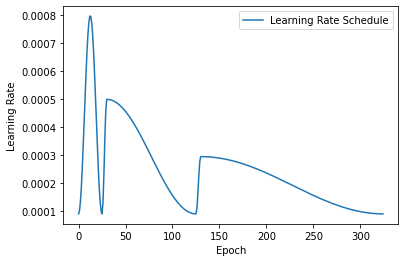

In [72]:
xx = [schedule.cosine_annealing_schedule(i) for i in range(325)]
plt.plot(xx,label="Learning Rate Schedule")
plt.xlabel("Epoch")
plt.legend()
plt.ylabel("Learning Rate")
plt.show()


In [73]:
%time
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=512,
    epochs=325,
    class_weight=class_weight_dict,
    # validation_split=0.2,
    shuffle=True,
    callbacks=[tensorboard_callback,lr_scheduler],
)
model.save(filepath=outdir+"model_post_fit.keras")

CPU times: user 8 µs, sys: 2 µs, total: 10 µs
Wall time: 25.7 µs
Epoch 1/325
399/399 [==============================] - 6s 8ms/step - loss: 0.5128 - accuracy: 0.7761 - val_loss: 0.5001 - val_accuracy: 0.7857 - lr: 9.0000e-05
Epoch 2/325
399/399 [==============================] - 3s 7ms/step - loss: 0.5067 - accuracy: 0.7806 - val_loss: 0.5068 - val_accuracy: 0.7810 - lr: 1.0115e-04
Epoch 3/325
399/399 [==============================] - 3s 7ms/step - loss: 0.5056 - accuracy: 0.7800 - val_loss: 0.4986 - val_accuracy: 0.7865 - lr: 1.3391e-04
Epoch 4/325
399/399 [==============================] - 3s 7ms/step - loss: 0.5055 - accuracy: 0.7820 - val_loss: 0.4966 - val_accuracy: 0.7880 - lr: 1.8622e-04
Epoch 5/325
399/399 [==============================] - 3s 7ms/step - loss: 0.5044 - accuracy: 0.7818 - val_loss: 0.5019 - val_accuracy: 0.7859 - lr: 2.5478e-04
Epoch 6/325
399/399 [==============================] - 3s 7ms/step - loss: 0.5062 - accuracy: 0.7828 - val_loss: 0.5028 - val_accuracy:

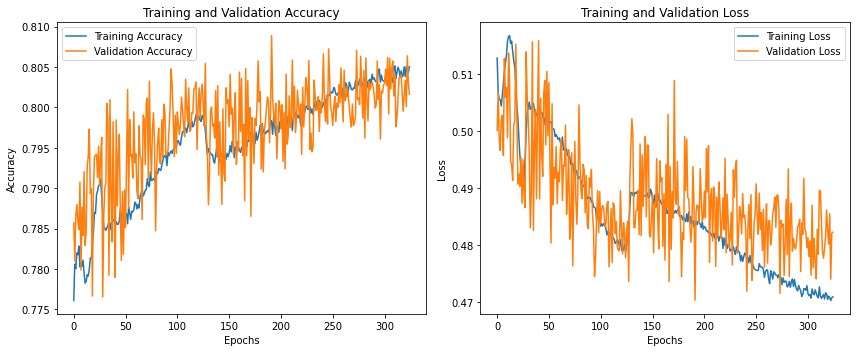

In [76]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']



# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot( accuracy, label='Training Accuracy')
plt.plot( val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

4250/4250 [==============================] - 7s 2ms/step


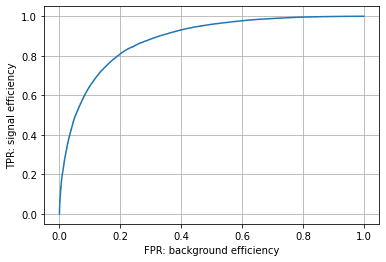

In [77]:
y_test_pred1 = model.predict(X_test)
from sklearn.metrics import roc_curve

fpr1, tpr1, thr1 = roc_curve(y_test, y_test_pred1, drop_intermediate=False)

plt.plot(fpr1, tpr1)
plt.xlabel("FPR: background efficiency")
plt.ylabel("TPR: signal efficiency")
plt.grid()


### If you just want "a model" you can stop here the rest of the notebook is for the evaluation of the performance of the learning rate scheduler the difference in performance should not exceed 2% compared to  model_post_fit.keras


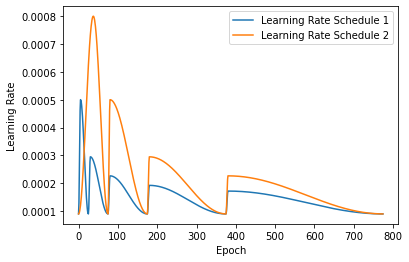

In [54]:
from keras.models import load_model
# model = load_model("/home/elias/taubus/logs/20240729-120116model")
import keras.metrics

import cosan
d = cosan.CosineAnnealingScheduler()
d.set_lr_max_warmup(0.0005)
d.set_lr_max(0.0005)
d.set_lr_min(0.00009)
d.set_multiplier(2)
d.set_rise_epochs(5)
d.set_warmup_epochs(0)
d.set_cycle_length(25)

e = cosan.CosineAnnealingScheduler()
e.set_lr_max_warmup(0.0008)
e.set_lr_max(0.0005)
e.set_lr_min(0.00009)
e.set_multiplier(2)
e.set_rise_epochs(5)
e.set_warmup_epochs(75)
e.set_cycle_length(100)

d.ampmod = True
lr_scheduler = LearningRateScheduler(d.cosine_annealing_schedule)
lr_scheduler2 = LearningRateScheduler(e.cosine_annealing_schedule)

xx = [d.cosine_annealing_schedule(i) for i in range(775)]
yy = [e.cosine_annealing_schedule(i) for i in range(775)]
plt.plot(xx,label="Learning Rate Schedule 1")
plt.plot(yy,label="Learning Rate Schedule 2")
plt.xlabel("Epoch")
plt.legend()
plt.ylabel("Learning Rate")
plt.show()


In [ ]:
model_cloned_1 = tf.keras.models.clone_model(model)
model_cloned_1.compile(
        optimizer=Adam(learning_rate=1e-4),

        loss=['binary_crossentropy'], metrics=['accuracy',
        keras.metrics.BinaryAccuracy(),
        keras.metrics.FalseNegatives(),
    ],

)



%time
history1 = model_cloned_1.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=512,
    epochs=775,
    class_weight=class_weight_dict,
    # validation_split=0.2,
    shuffle=True,
    callbacks=[tensorboard_callback],
)


model_cloned_2 = tf.keras.models.clone_model(model)
model_cloned_2.compile(
        optimizer=Adam(learning_rate=1e-3),

        loss=['binary_crossentropy'], metrics=['accuracy',
        keras.metrics.BinaryAccuracy(),
        keras.metrics.FalseNegatives(),
    ],

)






CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 29.8 µs
Epoch 1/775
399/399 [==============================] - 6s 9ms/step - loss: 3.7132 - accuracy: 0.6179 - binary_accuracy: 0.6179 - false_negatives_4: 20322.0000 - val_loss: 2.7948 - val_accuracy: 0.6801 - val_binary_accuracy: 0.6801 - val_false_negatives_4: 11810.0000
Epoch 2/775
399/399 [==============================] - 3s 8ms/step - loss: 2.1780 - accuracy: 0.6767 - binary_accuracy: 0.6767 - false_negatives_4: 14580.0000 - val_loss: 1.6680 - val_accuracy: 0.6893 - val_binary_accuracy: 0.6893 - val_false_negatives_4: 8494.0000
Epoch 3/775
399/399 [==============================] - 3s 8ms/step - loss: 1.3968 - accuracy: 0.6936 - binary_accuracy: 0.6936 - false_negatives_4: 12920.0000 - val_loss: 1.2190 - val_accuracy: 0.6818 - val_binary_accuracy: 0.6818 - val_false_negatives_4: 6985.0000
Epoch 4/775
399/399 [==============================] - 3s 8ms/step - loss: 1.0944 - accuracy: 0.7034 - binary_accuracy: 0.7034 - fals

In [57]:
%time
history2 = model_cloned_2.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=512,
    epochs=775,
    class_weight=class_weight_dict,
    # validation_split=0.2,
    shuffle=True,
    callbacks=[tensorboard_callback,lr_scheduler],
)


CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 31.9 µs
Epoch 1/775
399/399 [==============================] - 4s 8ms/step - loss: 0.4601 - accuracy: 0.8119 - binary_accuracy: 0.8119 - false_negatives_5: 8426.0000 - val_loss: 0.5052 - val_accuracy: 0.7968 - val_binary_accuracy: 0.7968 - val_false_negatives_5: 6616.0000 - lr: 9.0000e-05
Epoch 2/775
399/399 [==============================] - 3s 8ms/step - loss: 0.4632 - accuracy: 0.8105 - binary_accuracy: 0.8105 - false_negatives_5: 8492.0000 - val_loss: 0.4921 - val_accuracy: 0.8054 - val_binary_accuracy: 0.8054 - val_false_negatives_5: 7290.0000 - lr: 1.2915e-04
Epoch 3/775
399/399 [==============================] - 3s 8ms/step - loss: 0.4728 - accuracy: 0.8052 - binary_accuracy: 0.8052 - false_negatives_5: 8732.0000 - val_loss: 0.4995 - val_accuracy: 0.7994 - val_binary_accuracy: 0.7994 - val_false_negatives_5: 7024.0000 - lr: 2.3165e-04
Epoch 4/775
399/399 [==============================] - 3s 8ms/step - loss: 0.4868 - accu

In [58]:
model_cloned_3 = tf.keras.models.clone_model(model)
model_cloned_3.compile(
        optimizer=Adam(learning_rate=1e-3),

        loss=['binary_crossentropy'], metrics=['accuracy',
        keras.metrics.BinaryAccuracy(),
        keras.metrics.FalseNegatives(),
    ],

)


history3 = model_cloned_3.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=512,
    epochs=775,
    class_weight=class_weight_dict,
    # validation_split=0.2,
    shuffle=True,
    callbacks=[tensorboard_callback,lr_scheduler2],
)


Epoch 1/775
399/399 [==============================] - 8s 9ms/step - loss: 3.8071 - accuracy: 0.6062 - binary_accuracy: 0.6062 - false_negatives_7: 21449.0000 - val_loss: 2.9647 - val_accuracy: 0.6577 - val_binary_accuracy: 0.6577 - val_false_negatives_7: 12533.0000 - lr: 9.0000e-05
Epoch 2/775
399/399 [==============================] - 3s 8ms/step - loss: 2.3420 - accuracy: 0.6637 - binary_accuracy: 0.6637 - false_negatives_7: 16575.0000 - val_loss: 1.7957 - val_accuracy: 0.6968 - val_binary_accuracy: 0.6968 - val_false_negatives_7: 10622.0000 - lr: 9.1245e-05
Epoch 3/775
399/399 [==============================] - 3s 8ms/step - loss: 1.4896 - accuracy: 0.6889 - binary_accuracy: 0.6889 - false_negatives_7: 13892.0000 - val_loss: 1.2444 - val_accuracy: 0.7065 - val_binary_accuracy: 0.7065 - val_false_negatives_7: 9267.0000 - lr: 9.4971e-05
Epoch 4/775
399/399 [==============================] - 3s 8ms/step - loss: 1.1297 - accuracy: 0.7011 - binary_accuracy: 0.7011 - false_negatives_7: 1

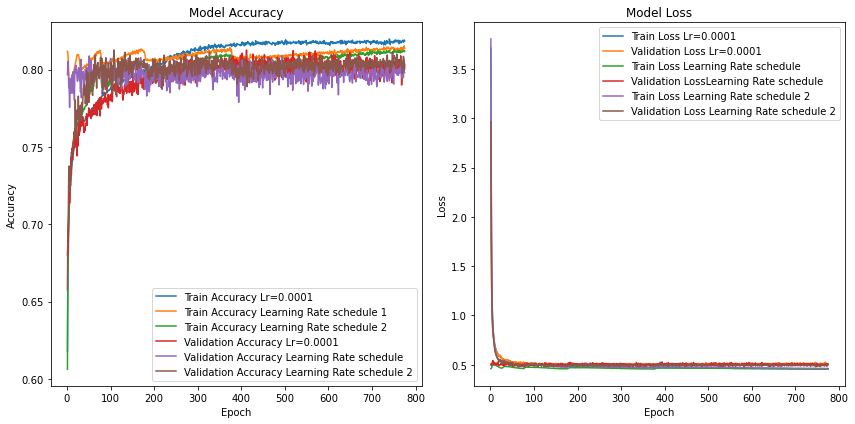

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
history2 = history2
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, len(history1.history['accuracy']) + 1), y=history1.history['accuracy'], label='Train Accuracy Lr=0.0001')
sns.lineplot(x=range(1, len(history2.history['accuracy']) + 1), y=history2.history['accuracy'], label='Train Accuracy Learning Rate schedule 1')
sns.lineplot(x=range(1, len(history3.history['accuracy']) + 1), y=history3.history['accuracy'], label='Train Accuracy Learning Rate schedule 2')
sns.lineplot(x=range(1, len(history1.history['val_accuracy']) + 1), y=history1.history['val_accuracy'], label='Validation Accuracy Lr=0.0001')
sns.lineplot(x=range(1, len(history2.history['val_accuracy']) + 1), y=history2.history['val_accuracy'], label='Validation Accuracy Learning Rate schedule ')
sns.lineplot(x=range(1, len(history3.history['val_accuracy']) + 1), y=history3.history['val_accuracy'], label='Validation Accuracy Learning Rate schedule 2')

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, len(history1.history['loss']) + 1), y=history1.history['loss'], label='Train Loss Lr=0.0001')
sns.lineplot(x=range(1, len(history1.history['val_loss']) + 1), y=history1.history['val_loss'], label='Validation Loss Lr=0.0001')
sns.lineplot(x=range(1, len(history2.history['loss']) + 1), y=history2.history['loss'], label='Train Loss Learning Rate schedule ')
sns.lineplot(x=range(1, len(history2.history['val_loss']) + 1), y=history2.history['val_loss'], label='Validation LossLearning Rate schedule ')
sns.lineplot(x=range(1, len(history3.history['loss']) + 1), y=history3.history['loss'], label='Train Loss Learning Rate schedule 2')
sns.lineplot(x=range(1, len(history3.history['val_loss']) + 1), y=history3.history['val_loss'], label='Validation Loss Learning Rate schedule 2')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model_cloned_4 = tf.keras.models.clone_model(model)
model_cloned_4.compile(
        optimizer=Adam(learning_rate=1e-3),

        loss=['binary_crossentropy'], metrics=['accuracy',
        keras.metrics.BinaryAccuracy(),
        keras.metrics.FalseNegatives(),
    ],

        )
model_cloned_5 = tf.keras.models.clone_model(model)
model_cloned_5.compile(
        optimizer=Adam(learning_rate=1e-3),

        loss=['binary_crossentropy'], metrics=['accuracy',
        keras.metrics.BinaryAccuracy(),
        keras.metrics.FalseNegatives(),
    ],

        )




lr_scheduler = LearningRateScheduler(d.cosine_annealing_schedule)
%time
history4 = model_cloned_4.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=640,
    class_weight=class_weight_dict,
    # validation_split=0.2,
    shuffle=True,
    callbacks=[tensorboard_callback,lr_scheduler],
)
history5 = model_cloned_5.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=640,
    class_weight=class_weight_dict,
    # validation_split=0.2,
    shuffle=True,
    callbacks=[tensorboard_callback,lr_scheduler2],
)

In [60]:
numbers = history1.history['val_loss']
min_value = min(numbers)
min_index = numbers.index(min_value)

print("Minimum  lrs const value:", min_value)
print("Index of minimum value:", min_index)


numbers = history1.history['val_accuracy']
min_value = max(numbers)
min_index = numbers.index(min_value)

print("Max acc lrs const value:", min_value)
print("Index of minimum value:", min_index)

numbers = history3.history['val_loss']
min_value = min(numbers)
min_index = numbers.index(min_value)

print("Minimum lrs2 value:", min_value)
print("Index of minimum value:", min_index)


numbers = history3.history['val_accuracy']
min_value = max(numbers)
min_index = numbers.index(min_value)

print("max acc lrs2 value:", min_value)
print("Index of minimum value:", min_index)

numbers = history2.history['val_accuracy']
min_value = max(numbers)
min_index = numbers.index(min_value)
print("max acc lrs1 value:", min_value)
print("Index of minimum value:", min_index)


numbers = history2.history['val_loss']
min_value = min(numbers)
min_index = numbers.index(min_value)

print("Minimum lrs1 value:", min_value)
print("Index of minimum value:", min_index)


Minimum  lrs const value: 0.48666834831237793
Index of minimum value: 411
Max acc lrs const value: 0.8126718997955322
Index of minimum value: 411
Minimum lrs2 value: 0.4746016561985016
Index of minimum value: 64
max acc lrs2 value: 0.8127013444900513
Index of minimum value: 107
max acc lrs1 value: 0.80906081199646
Index of minimum value: 492
Minimum lrs1 value: 0.48054972290992737
Index of minimum value: 50


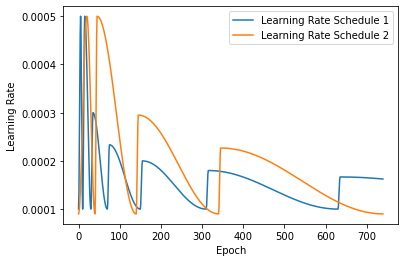

4250/4250 [==============================] - 7s 2ms/step


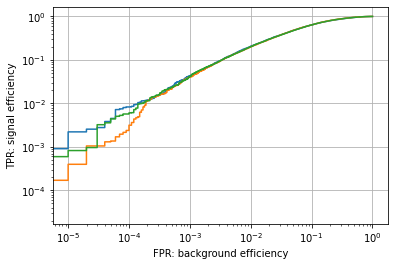

In [62]:
y_test_pred1 = model_cloned_1.predict(X_test)
y_test_pred3 = model_cloned_3.predict(X_test)
y_test_pred2 = model_cloned_2.predict(X_test)

from sklearn.metrics import roc_curve

fpr1, tpr1, thr1 = roc_curve(y_test, y_test_pred1, drop_intermediate=False)
fpr3, tpr3, thr3 = roc_curve(y_test, y_test_pred3, drop_intermediate=False)
fpr2, tpr2, thr2 = roc_curve(y_test, y_test_pred2, drop_intermediate=False)

plt.plot(fpr1, tpr1)
plt.plot(fpr3, tpr3)

plt.plot(fpr2, tpr2)
plt.loglog()
plt.xlabel("FPR: background efficiency")
plt.ylabel("TPR: signal efficiency")
plt.grid()


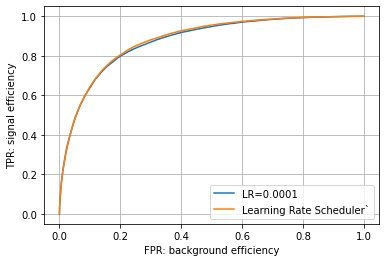

In [63]:
plt.plot(fpr1, tpr1, label = "LR=0.0001")
plt.plot(fpr3, tpr3, label = "Learning Rate Scheduler`")

plt.xlabel("FPR: background efficiency")
plt.ylabel("TPR: signal efficiency")
plt.legend()
plt.grid()





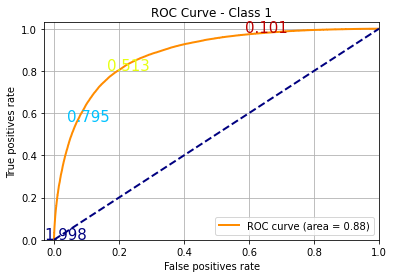

In [64]:
import sklearn # for the roc curve
import matplotlib.pyplot as plt

def plot_roc(labels, predictions, positive_label, thresholds_every=10, title=''):
  # fp: false positive rates. tp: true positive rates
  fp, tp, thresholds = sklearn.metrics.roc_curve(labels, predictions, pos_label=positive_label)
  roc_auc = sklearn.metrics.auc(fp, tp)

  # figure(figsize=(16, 16))
  plt.plot(fp, tp, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=2, color='darkorange')
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--', linewidth=2)
  plt.xlabel('False positives rate')
  plt.ylabel('True positives rate')
  plt.xlim([-0.03, 1.0])
  plt.ylim([0.0, 1.03])
  plt.title(title)
  plt.legend(loc="lower right")
  plt.grid(True)

  # plot some thresholds
  thresholdsLength = len(thresholds)
  colorMap=plt.get_cmap('jet', thresholdsLength)
  for i in range(0, thresholdsLength, thresholds_every):
    threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
    plt.text(fp[i] - 0.03, tp[i] + 0.005, threshold_value_with_max_four_decimals, fontdict={'size': 15}, color=colorMap(i/thresholdsLength));
  plt.show()


plot_roc(y_test, y_test_pred3, positive_label=1, thresholds_every=10000, title="ROC Curve")

/tmp/ipykernel_535/3108597816.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

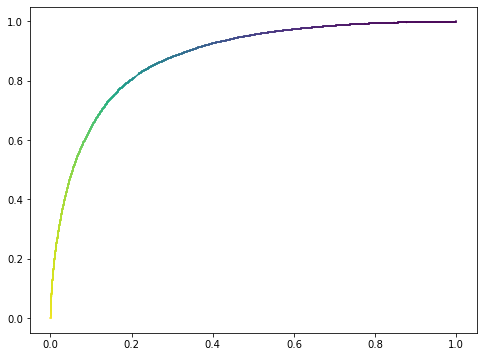

In [65]:
# Normalize thresholds for colormap


import matplotlib.cm as cm
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred3, drop_intermediate=False)

# norm_thresholds = (thresholds - thresholds.min()) / (thresholds.max() - thresholds.min())

# Create a color map
cmap = cm.get_cmap('viridis')

# Plot the ROC curve with varying colors
plt.figure(figsize=(8, 6))
for i in range(len(fpr) - 1):
    plt.plot(fpr[i:i+2], tpr[i:i+2], color=cmap(thresholds[i]))

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Threshold')

# Annotate some threshold values on the curve
threshold_points = [0.2, 0.5, 0.8]
for t in threshold_points:
    idx = np.argmin(np.abs(thresholds - t))
    plt.text(fpr[idx], tpr[idx], f'Thr. = {t:.2f}', 
             verticalalignment='bottom', horizontalalignment='right', color='black', fontsize=10)

# Plot labels and show the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Threshold-Based Color')
plt.show()

In [35]:
print(thresholds[-2])

1.418485e-13


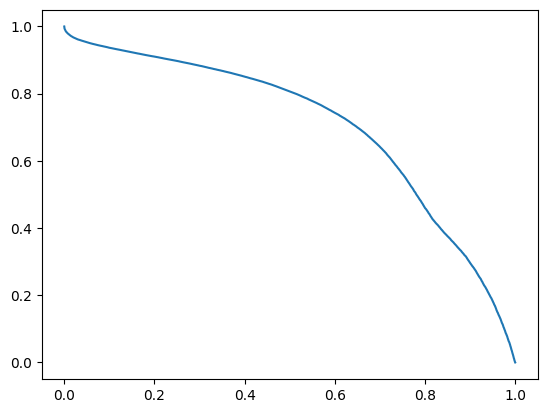

In [26]:
plt.plot(tpr3, thr3, label = "Learning Rate Scheduler`")


In [ ]:
# lr_scheduler = LearningRateScheduler(cosine_annealing_schedule)
%time
history10 = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=500,
    class_weight=class_weight_dict,
    validation_split=0.2,
    shuffle=True,
    callbacks= tensorboard_callback,
)

In [61]:
import os
from datetime import datetime
# from tensorflow.keras.models import Sequential



models = [model_cloned_1,model_cloned_2,model_cloned_3]
model_names = ["lrconst.keras","lrs1.keras","lrs2.keras","lrs1smallbatch.keras","lrs2smallbatch.keras",]
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_dir = f'models_{timestamp}'
# Create the directory
os.makedirs(save_dir, exist_ok=True)

# Save each model in the directory
for i, model in enumerate(models):
    model_path = os.path.join(save_dir, model_names[i])
    model.save(model_path)
    print(f"Saved {model_names[i]} at {model_path}")

#     Cosine annealing schedule.


Saved lrconst.keras at models_20240908_081719/lrconst.keras
Saved lrs1.keras at models_20240908_081719/lrs1.keras
Saved lrs2.keras at models_20240908_081719/lrs2.keras


In [ ]:
    
#     Parameters:
#     - epoch: int, the current epoch number.
#     - lr: float, the current learning rate.
    
#     Returns:
#     - new_lr: float, the updated learning rate.
#     """
#     initial_lr = 0.01
#     min_lr = 0.0001
#     total_epochs = 1000

#     cosine_decay = 0.5 * (1 + np.cos(np.pi * epoch / total_epochs))
#     new_lr = min_lr + (initial_lr - min_lr) * cosine_decay
#     return float(new_lr)

# # Create the LearningRateScheduler callback
# lr_scheduler = LearningRateScheduler(cosine_annealing_schedule)
# %time
# history = model.fit(
#     X_train,
#     y_train,
#     batch_size=256,
#     epochs=1000,
#     class_weight=class_weight_dict,
#     validation_split=0.2,
#     shuffle=True,
#     callbacks=[tensorboard_callback,lr_scheduler],
# )
# lr_scheduler = LearningRateScheduler(d.cosine_annealing_schedule)
%time

d = cosan.Cosine_annealing()
d.lr_max_warmup = 0.005
d.lr_max = 0.0005
d.lr_min = 0.0001
d.multiplier = 2
d.ampmod = True
lr_scheduler = LearningRateScheduler(d.cosine_annealing_schedule)
d.warmup_epochs = 10
history4 = model_cloned_2.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=1250,
    class_weight=class_weight_dict,
    validation_split=0.2,
    shuffle=True,
    callbacks=[tensorboard_callback,lr_scheduler],
)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 512)               184832    
                                                                 
 relu1 (Activation)          (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 fc2 (Dense)                 (None, 32)                16416     
                                                                 
 relu2 (Activation)          (None, 32)                0         
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 fc3 (Dense)                 (None, 48)                1

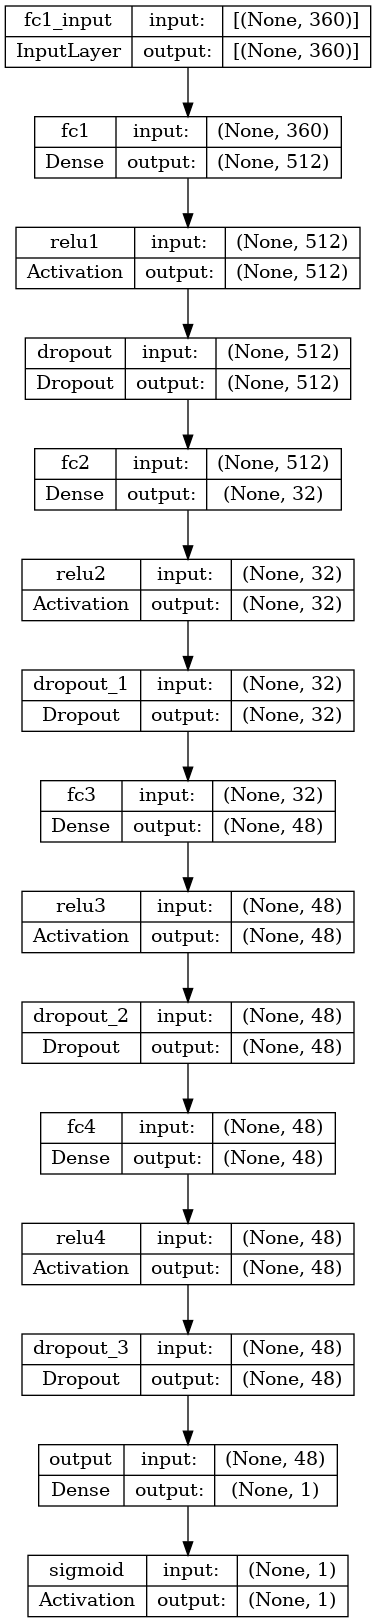

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


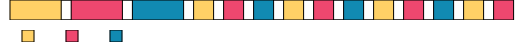

In [ ]:
import visualkeras
visualkeras.layered_view(model, legend=True, draw_volume=False)

In [ ]:

history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=1000,
    class_weight=class_weight_dict,
    validation_split=0.2,
    shuffle=True,
    callbacks=[tensorboard_callback,lr_scheduler],
)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    class_weight=class_weight_dict,
    validation_split=0.2,
    shuffle=True,
    
    callbacks=tensorboard_callback,
)

In [ ]:
model = tuner.hypermodel.build(best_hps)
# history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)
tensorboard_callback = tf.keras.callbacks.TensorBoard(outdir, histogram_freq=1)
print(outdir)


/home/elias/taubus/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


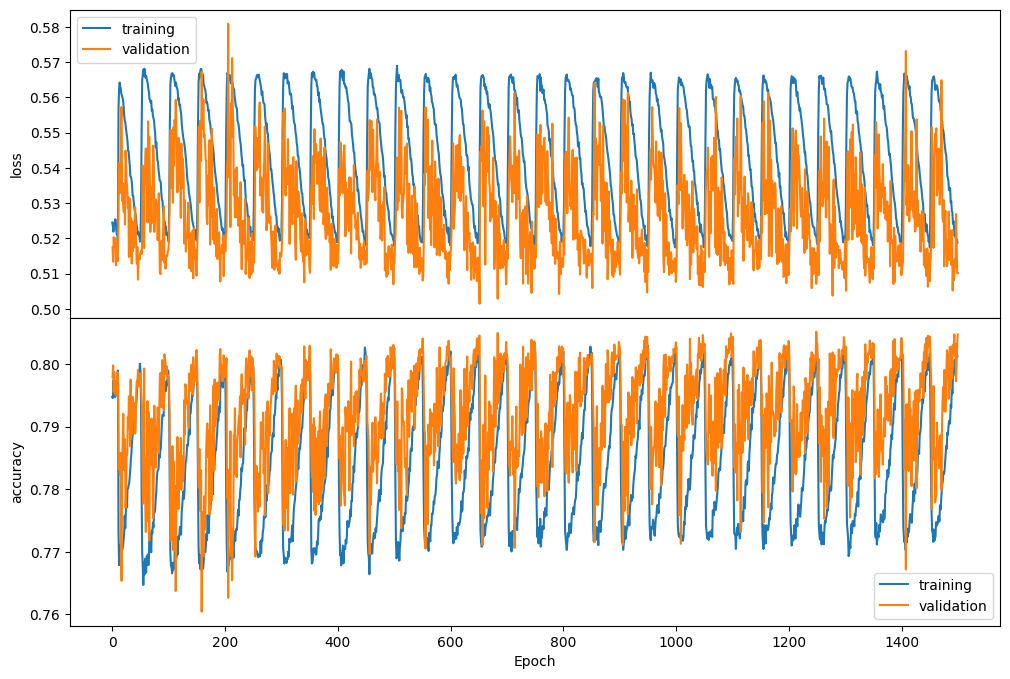

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pickle
def plotTrainingHistory(history, metrics = ["loss", "accuracy"], f = None, axs = None):

    # creating the plot
    if not f and not axs: 
        f, axs = plt.subplots(len(metrics), 1, figsize = (12, 4*len(metrics)), sharex = True)
    if len(metrics) == 1:
        axs = [axs]
    plt.subplots_adjust(wspace=0, hspace=0)

    # labeling
#     hep.cms.label("private work", data=False, ax=axs[0])

    for i in range(len(metrics)):
        
        metric = metrics[i]
        ax = axs[i]
        ax.set_ylabel(metric)
        
        if isinstance(history, list): # handle kfold
            for foldi in range(len(history)):
                ax.plot(history[foldi].history[metric], color = "C{}".format(foldi))
                ax.plot(history[foldi].history['val_' + metric], color = "C{}".format(foldi), linestyle = "--")
                
            la2, = ax.plot([0,0], [0,0], color="Grey")
            lb2, = ax.plot([0,0], [0,0], color="Grey", linestyle = "--")
            ax.legend([la2, lb2], ["training", "validation"])
        else: 
            xs = np.arange(len(history.history['val_' + metric]))
            ax.plot(xs,history.history[metric], label = 'training')
            ax.plot(xs+.5, history.history['val_' + metric], label= 'validation')
            ax.legend()

    axs[-1].set_xlabel("Epoch")
    
    return f, axs


model.save(outdir + "/model.h5")

with open(outdir + "/history.pkl", 'wb') as file_pi: pickle.dump(history, file_pi)

fig = plotTrainingHistory(history)



In [ ]:
y_test_pred = model.predict(X_test)  # Save predictions:
ak.to_parquet(y_test_pred, outdir+"y_test_pred.parquet")  
from sklearn.metrics import roc_curve

fpr, tpr, thr = roc_curve(y_test, y_test_pred, drop_intermediate=False)

def totalMinBiasRate(nCollBunch = 2500):
    LHCfreq = 11245.6
    return LHCfreq * nCollBunch / 1e3 # in kHz


plt.plot(fpr * totalMinBiasRate(), tpr)
plt.xlabel("FPR*MBrate: Trigger rate [kHz]")
plt.ylabel("TPR: signal efficiency")
plt.grid()
plt.xlim(0,1000)

In [ ]:
%time
y_test_pred = model.predict(X_test)  # Save predictions:
ak.to_parquet(y_test_pred, outdir+"y_test_pred.parquet")  

from sklearn.metrics import roc_curve

fpr, tpr, thr = roc_curve(y_test, y_test_pred, drop_intermediate=False)  
plt.plot(fpr, tpr)
plt.xlabel("FPR: background efficiency")
plt.ylabel("TPR: signal efficiency")
plt.xscale('log')
plt.grid()
plt.savefig(outdir+'efficiency.png')

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thr = roc_curve(y_test, y_test_pred, drop_intermediate=False)  
plt.plot(fpr, tpr)
plt.xlabel("FPR: background efficiency")
plt.ylabel("TPR: signal efficiency")
# plt.xscale('log')
plt.grid()
plt.savefig(outdir+'efficiency.png')